In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats = ('svg', 'retina')
plt.style.use('my_custom_style')

In [4]:
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)



# Batch Normalization

In [ ]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder(tf.bool, shape=(), name="is_training")


hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn1 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)


## Vanilla RNN

Below is a vanilla recurrent neural network (RNN) to illusrate the concept of this type neural nets. 

- For an RNN with a single recurrent neuron, the output can be written as
$y_{(t)}=\phi(x_{(t)}^T\cdot w_x + y_{(t-1)} w_y + b)$. Note that the output of the previous state is now a feature of the current state.

- For a mini-batch of the shape $m\times n_{neurons}$, the prediction of the current state can be written as

$$
\begin{align*}
Y_{(t)} &= \phi(X_{(t)}\cdot W_x + Y_{(t-1)}\cdot W_y + b) \\
    &= \phi([X_{(t)} Y_{(t-1)}]\cdot W + b)
\end{align*}    
$$

where $\mathbf{W} = [\mathbf{W}_x \mathbf{W}_y]^T$.

- $\mathbf{W}_x$ is an $n_{inputs}\times n_{neurons}$ matrix
- $W_y$ is an $n_{neurons}\times n_{neurons}$ matrix
- $X_{(t)}$ is an $m\times n_{inputs}$ matrix
- $Y_{(t)}$ is an $m\times n_{neurons}$ matrix
- $b$ is a vector of size $n_{neurons}$

In [ ]:
## pseudo RNN for illustration
class RNN:
    #...
    def step(self, x):
        # update the hidden state
        self.h = np.tanh(np.dot(self.W_hh, self.h) + np.dot(self.W_xh, x))
        # compute the output vector
        y = np.dot(self.W_hy, self.h)
        return y

## ## Manual RNN

In [5]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons]))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons]))
b = tf.Variable(tf.zeros([1, n_neurons]))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()


In [11]:
# a mini-batch with four instances
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t=0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t=1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

print('Output at t=0\n\n', Y0_val)
print("="*80)
print('Output at t=1\n\n', Y1_val)

Output at t=0

 [[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]
Output at t=1

 [[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


Since our naive RNN has only five neurons, and the mini-batch is of shape $4\times 3$, and thus the  shape of the output Y1_val should be $(4\times 3) \times (3\times 5) = (4\times 5)$.

## Static Unrolling

In [25]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t=0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t=1

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    Y0_val, Y1_val, states_ = sess.run([Y0, Y1, states], feed_dict={X0: X0_batch, X1: X1_batch})

In [27]:
print('Output at t=0\n\n', Y0_val)
print("="*80)
print('Output at t=1\n\n', Y1_val)
print("="*80)
print("Final states are\n", states_) # this is simply the last output

Output at t=0

 [[ 0.30741334 -0.32884315 -0.6542847  -0.9385059   0.52089024]
 [ 0.99122757 -0.9542541  -0.7518079  -0.9995208   0.9820235 ]
 [ 0.9999268  -0.99783254 -0.8247353  -0.9999963   0.99947774]
 [ 0.996771   -0.68750614  0.8419969   0.9303911   0.8120684 ]]
Output at t=1

 [[ 0.99998885 -0.99976057 -0.0667929  -0.9999803   0.99982214]
 [-0.6524943  -0.51520866 -0.37968948 -0.5922594  -0.08968379]
 [ 0.99862397 -0.99715203 -0.03308626 -0.9991566   0.9932902 ]
 [ 0.99681675 -0.9598194   0.39660627 -0.8307606   0.79671973]]
Final states are
 [[ 0.99998885 -0.99976057 -0.0667929  -0.9999803   0.99982214]
 [-0.6524943  -0.51520866 -0.37968948 -0.5922594  -0.08968379]
 [ 0.99862397 -0.99715203 -0.03308626 -0.9991566   0.9932902 ]
 [ 0.99681675 -0.9598194   0.39660627 -0.8307606   0.79671973]]


Handle long time-steps

In [28]:
reset_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
# swap the positions of time-steps and features in X
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2])) 
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell,
                                                X_seqs, dtype=tf.float32)
# change the shape of output back to that of X
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

X_batchs = np.array([
    [[0, 1, 2], [9, 8, 7]],
    [[3, 4, 5], [0, 0, 0]],
    [[6, 7, 8], [6, 5, 4]],
    [[9, 0, 1], [3, 2, 1]],
])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batchs})

In [29]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971032  -0.9964609 ]
  [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]]


The static rolling method is still problematic, as it will need to creat n_steps copies of the basic RNN cell. As the n_steps increases, we will face the out-of-memory problem, especially when using GPU. 

## Use dynamic unrolling

In [31]:
reset_graph()

n_inputs = 3
n_steps = 2
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

X_batchs = np.array([
    [[0, 1, 2], [9, 8, 7]],
    [[3, 4, 5], [0, 0, 0]],
    [[6, 7, 8], [6, 5, 4]],
    [[9, 0, 1], [3, 2, 1]],
])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batchs})

In [33]:
print("Used dynamic_rnn\n\n", outputs_val)

Used dynamic_rnn

 [[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.999996    0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.85227895  0.5845349  -0.78780943]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.99999976 -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624866   0.99817705  0.80142   ]]]


## Setting the sequence length

`help(tf.nn.dynamic_rnn)`

```python
dynamic_rnn(cell, inputs, sequence_length=None, initial_state=None, dtype=None, parallel_iterations=None, swap_memory=False, time_major=False, scope=None)
```

In [36]:
reset_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
seq_length = tf.placeholder(tf.int32, [None])

outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)


X_batch = np.array([
    [[0, 1, 2], [9, 8, 7]],
    [[3, 4, 5], [0, 0, 0]], # (padded with zero vector)
    [[6, 7, 8], [6, 5, 4]],
    [[9, 0, 1], [3, 2, 1]],
])

seq_length_batch = np.array([2, 1, 2, 2])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    outputs_val, states_val = sess.run([outputs, states],
                                       feed_dict={X: X_batch,
                                                  seq_length: seq_length_batch})

In [38]:
print("with sequence length manually setted\n\n", outputs_val)
print("\n", "="*60)
print(states_val)


with sequence length manually setted

 [[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.956726    0.99831694  0.99970174  0.96518576]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.93662   ]
  [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]]

[[-1.          0.956726    0.99831694  0.99970174  0.96518576]
 [-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
 [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]
 [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]


# Training a sequence classifier

Training a RNN classifier for MNIST images. Treat an image as a sequence! A MNIST image is of the shape $28\times 28$, we can treat it as a sequence of 28 rows of 28 pixels each.

In [53]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 100
n_outputs = 10 # number of digits (0-9)

learning_rate = 1e-3

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits_ = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits_)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits_, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [60]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [61]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.93333334 Test accuracy: 0.9311


1 Train accuracy: 0.96666664 Test accuracy: 0.9522


2 Train accuracy: 0.97333336 Test accuracy: 0.9586


3 Train accuracy: 0.96666664 Test accuracy: 0.9607


4 Train accuracy: 0.97333336 Test accuracy: 0.9673


5 Train accuracy: 0.98 Test accuracy: 0.9669


6 Train accuracy: 0.97333336 Test accuracy: 0.9693


7 Train accuracy: 0.96666664 Test accuracy: 0.968


8 Train accuracy: 0.9533333 Test accuracy: 0.9723


9 Train accuracy: 0.97333336 Test accuracy: 0.9683


This is just a toy example, my poor macbook pro cannot handle more trianing eopochs and smaller learning rate. Otherwise, it will take forever to finish the training.

Anyhow, we achieved a test accuracy about 97% at nine epochs. Noting that the RNN starts to overfitting at the 10th epoch, given the relatively large learning rate (lr=1e-3).

# RNN for Time Series

In [86]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.randn(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps+1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

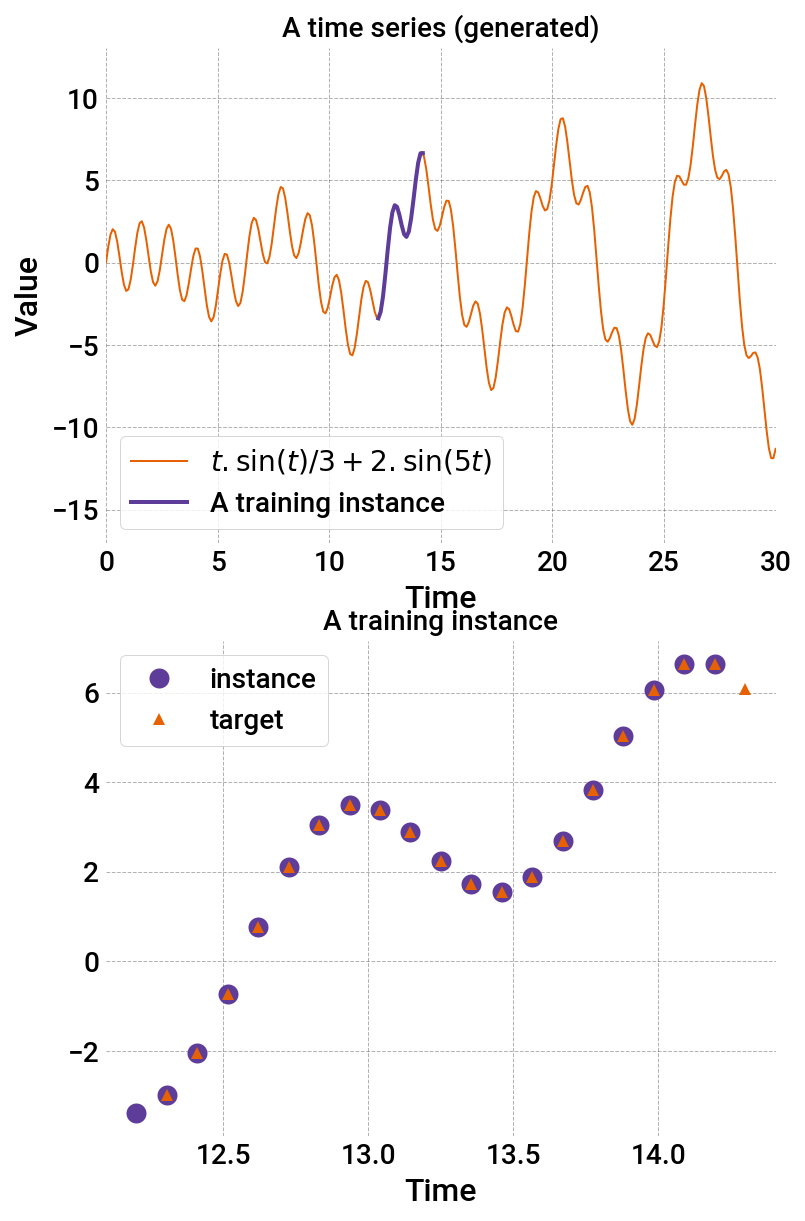

In [81]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']

plt.figure(figsize=(6,10))
plt.subplot(211)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$", c=colors[0])
plt.plot(t_instance[:-1], time_series(t_instance[:-1]),
         "-", c=colors[3],
         linewidth=2, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(212)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]),
         "o", c=colors[3], markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]),
         "^", c=colors[0], markersize=6, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


plt.show()

In [90]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


In [96]:
lr = 1e-3

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [97]:
n_iter = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iter in range(n_iter):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iter % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iter, "\tMSE:", mse)
    saver.save(sess, "./my_time_series_model")

0 	MSE: 30.081484


100 	MSE: 1.0037302


200 	MSE: 0.31839588


300 	MSE: 0.117816605


400 	MSE: 0.08678536


500 	MSE: 0.07596365


600 	MSE: 0.07565194


700 	MSE: 0.063124284


800 	MSE: 0.079985745


900 	MSE: 0.09078568


1000 	MSE: 0.063434936


1100 	MSE: 0.070668414


1200 	MSE: 0.06726608


1300 	MSE: 0.066738725


1400 	MSE: 0.07327352


In [100]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


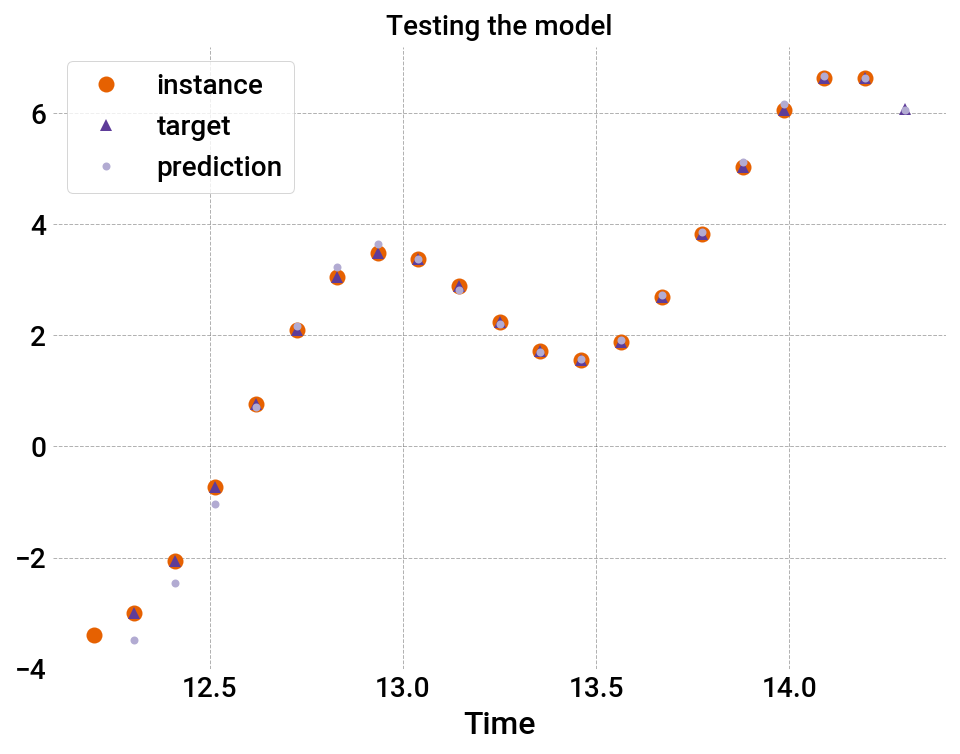

In [111]:
plt.subplots(figsize=(8, 8/1.4))
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]),
         "o", c=colors[0], markersize=8, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]),
         "^", c=colors[3], markersize=6, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0],
         ".", c=colors[2], markersize=8, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()